<a href="https://colab.research.google.com/github/SteveChengChen/data-analysis/blob/main/STAT_5243_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install kaggle
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip cell-images-for-detecting-malaria.zip
!mkdir /content/backup_nested_folder
!mv /content/cell_images/cell_images/* /content/backup_nested_folder
!rmdir /content/cell_images/cell_images

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

In [ ]:
!nvidia-smi

Thu Mar 13 19:02:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P0             48W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)

print("TensorFlow version:", tf.__version__)
print("GPU devices available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU devices available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Path to your dataset in Google Drive
# Contains two subfolders: Parasitized, Uninfected
data_dir = "/content/drive/MyDrive/STAT 5243/cell_images"

infected_dir = os.path.join(data_dir, "Parasitized")
uninfected_dir = os.path.join(data_dir, "Uninfected")

# List all image filenames in each class
infected_files = [f for f in os.listdir(infected_dir) if f.endswith('.png')]
uninfected_files = [f for f in os.listdir(uninfected_dir) if f.endswith('.png')]

print(f"Total 'Parasitized' images: {len(infected_files)}")
print(f"Total 'Uninfected' images: {len(uninfected_files)}")

Total 'Parasitized' images: 13779
Total 'Uninfected' images: 13779


In [38]:
# For demonstration and faster training, let's sample a smaller subset
# e.g., 1000 images from each class. Adjust as desired.
SAMPLE_SIZE = 3000
np.random.seed(42)  # For reproducible sampling
infected_sample = np.random.choice(infected_files, size=SAMPLE_SIZE, replace=False)
uninfected_sample = np.random.choice(uninfected_files, size=SAMPLE_SIZE, replace=False)

# Define local directories to store the small dataset
base_small = "data_small"
train_dir = os.path.join(base_small, "train")
val_dir   = os.path.join(base_small, "val")
test_dir  = os.path.join(base_small, "test")

# Create subdirectories for each class
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(split_dir, "Parasitized"), exist_ok=True)
    os.makedirs(os.path.join(split_dir, "Uninfected"), exist_ok=True)

# We'll do an 80/10/10 split for train/val/test
train_split = int(0.8 * SAMPLE_SIZE)   # 800
val_split   = int(0.9 * SAMPLE_SIZE)   # 900 => 100 for val, 100 for test

infected_train = infected_sample[:train_split]
infected_val   = infected_sample[train_split:val_split]
infected_test  = infected_sample[val_split:]

uninfected_train = uninfected_sample[:train_split]
uninfected_val   = uninfected_sample[train_split:val_split]
uninfected_test  = uninfected_sample[val_split:]

# Function to copy files into respective directories
def copy_files(file_list, src_dir, dst_dir):
    for fname in file_list:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        shutil.copy(src, dst)

# Copy infected class files
copy_files(infected_train, infected_dir, os.path.join(train_dir, "Parasitized"))
copy_files(infected_val,   infected_dir, os.path.join(val_dir, "Parasitized"))
copy_files(infected_test,  infected_dir, os.path.join(test_dir, "Parasitized"))

# Copy uninfected class files
copy_files(uninfected_train, uninfected_dir, os.path.join(train_dir, "Uninfected"))
copy_files(uninfected_val,   uninfected_dir, os.path.join(val_dir, "Uninfected"))
copy_files(uninfected_test,  uninfected_dir, os.path.join(test_dir, "Uninfected"))

print("Small dataset created with:")
print(f"  Train: {len(infected_train)} Parasitized + {len(uninfected_train)} Uninfected")
print(f"  Val:   {len(infected_val)} Parasitized + {len(uninfected_val)} Uninfected")
print(f"  Test:  {len(infected_test)} Parasitized + {len(uninfected_test)} Uninfected")

Small dataset created with:
  Train: 2400 Parasitized + 2400 Uninfected
  Val:   300 Parasitized + 300 Uninfected
  Test:  300 Parasitized + 300 Uninfected


In [39]:
# 2. IMAGE DATA GENERATORS
# ----------------------------------------------------------------------------

#
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

# Training data generator (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.2
)

# Validation and test data generator (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Class indices:", train_gen.class_indices)

Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Class indices: {'Parasitized': 0, 'Uninfected': 1}


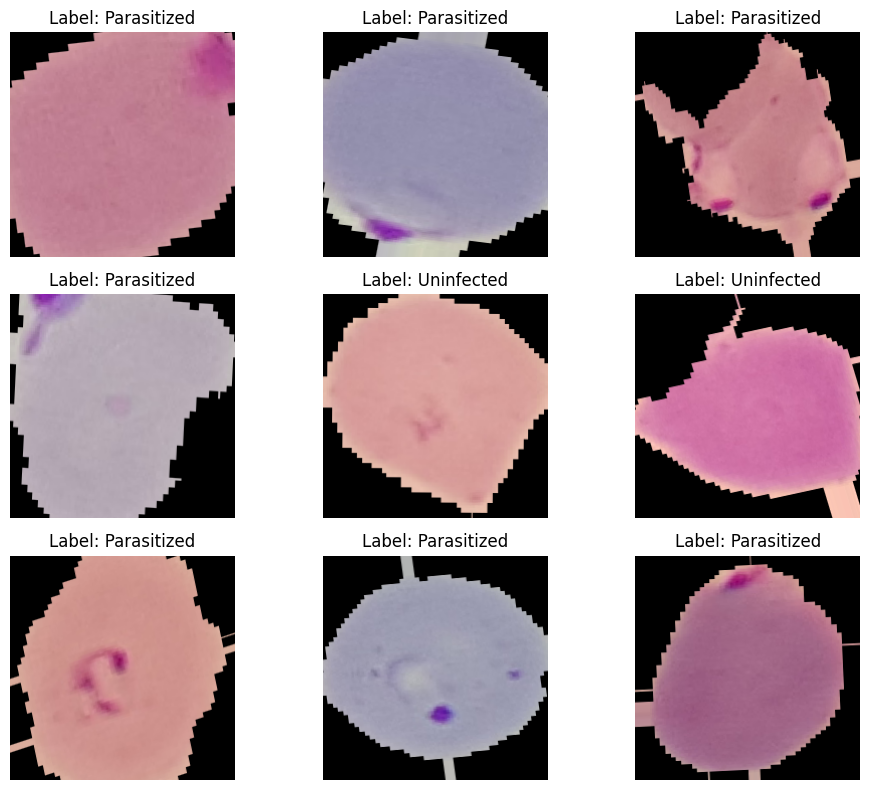

In [40]:
import matplotlib.pyplot as plt

# Get one batch of images and labels from the training generator
images, labels = next(train_gen)  # or next(train_generator), whichever variable holds the generator

# Display the first 9 images of the batch
plt.figure(figsize=(10,8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    # Convert the numeric label (0 or 1) to a meaningful string
    label_str = "Parasitized" if labels[i] == 0 else "Uninfected"
    plt.title(f"Label: {label_str}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [41]:
# 3. HELPER FUNCTIONS FOR EVALUATION AND PLOTTING
# ----------------------------------------------------------------------------

def evaluate_model(model, test_generator, model_name="Model"):
    """Evaluate model on test set and print classification metrics."""
    # True labels from the directory iterator
    y_true = test_generator.classes

    # Predict probabilities
    y_pred_proba = model.predict(test_generator)
    y_pred = (y_pred_proba.ravel() > 0.5).astype(int)

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba.ravel())

    print(f"{model_name} Performance on Test Set:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  AUC-ROC:   {auc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    return y_true, y_pred, cm

def plot_training_curves(history, model_name="Model"):
    """Plot training and validation accuracy/loss curves."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, model_name="Model"):
    """Plot confusion matrix as a heatmap."""
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Parasitized','Uninfected'],
                yticklabels=['Parasitized','Uninfected'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [42]:
# 4. BUILD & TRAIN MODELS (VGG16, ResNet50, MobileNetV2)
# ----------------------------------------------------------------------------

EPOCHS = 20  # Adjust as needed for your time constraints

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',     # stop when validation loss no longer improves
    patience=3,             # wait 3 epochs after no improvement
    restore_best_weights=True
)


In [43]:
# --------------------- VGG16 --------------------- #
tf.keras.backend.clear_session()
base_vgg = VGG16(weights='imagenet', include_top=False,
                 input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
base_vgg.trainable = False  # freeze pretrained layers

x = GlobalAveragePooling2D()(base_vgg.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_vgg = Dense(1, activation='sigmoid')(x)

model_vgg = Model(inputs=base_vgg.input, outputs=output_vgg)
model_vgg.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

print("\n--- Training VGG16 Model ---")
history_vgg = model_vgg.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    verbose=1
)


--- Training VGG16 Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 358ms/step - accuracy: 0.5058 - loss: 0.7351 - val_accuracy: 0.6200 - val_loss: 0.6618
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 338ms/step - accuracy: 0.5684 - loss: 0.6763 - val_accuracy: 0.7383 - val_loss: 0.6324
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 336ms/step - accuracy: 0.6368 - loss: 0.6367 - val_accuracy: 0.7550 - val_loss: 0.6067
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 340ms/step - accuracy: 0.7019 - loss: 0.6051 - val_accuracy: 0.7542 - val_loss: 0.5841
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 340ms/step - accuracy: 0.7490 - loss: 0.5747 - val_accuracy: 0.7775 - val_loss: 0.5588
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 338ms/step - accuracy: 0.7742 - loss: 0.5465 - val_accuracy: 0.7683 - val_loss: 0.5419
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 341ms/step - accuracy: 0.7747 - loss: 0.5343 - val_accuracy: 0.7992 - val_loss: 0.5169
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 337ms/step - accuracy: 0.7949 - loss: 0

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
VGG16 Performance on Test Set:
  Accuracy:  0.8225
  Precision: 0.7478
  Recall:    0.9733
  F1-score:  0.8458
  AUC-ROC:   0.9433
Confusion Matrix:
 [[403 197]
 [ 16 584]]


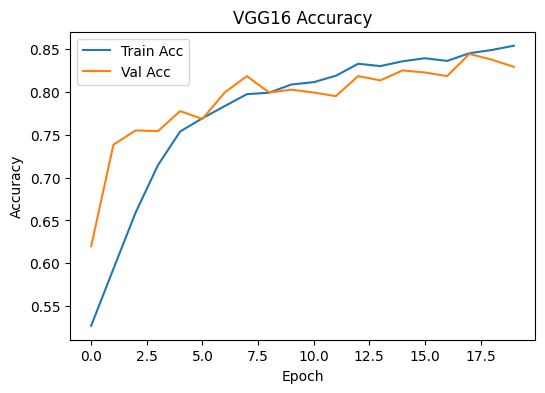

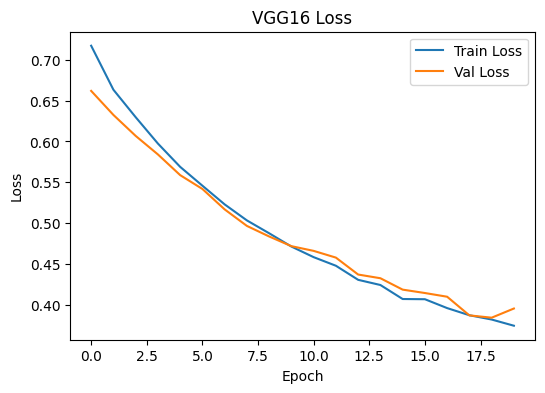

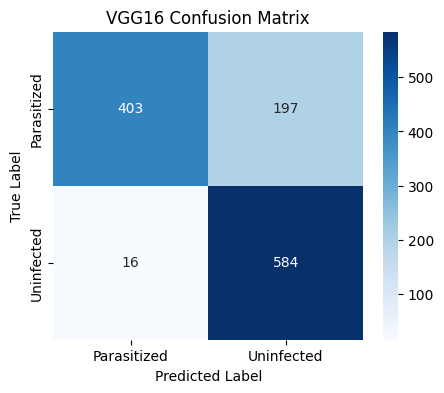

In [44]:
# Evaluate VGG16
y_true_vgg, y_pred_vgg, cm_vgg = evaluate_model(model_vgg, test_gen, "VGG16")
plot_training_curves(history_vgg, "VGG16")
plot_confusion_matrix(cm_vgg, "VGG16")

In [45]:
# --------------------- ResNet50 --------------------- #
tf.keras.backend.clear_session()
base_resnet = ResNet50(weights='imagenet', include_top=False,
                       input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
base_resnet.trainable = False

y = GlobalAveragePooling2D()(base_resnet.output)
y = Dense(128, activation='relu')(y)
y = Dropout(0.5)(y)
output_resnet = Dense(1, activation='sigmoid')(y)

model_resnet = Model(inputs=base_resnet.input, outputs=output_resnet)
model_resnet.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

print("\n--- Training ResNet50 Model ---")
history_resnet = model_resnet.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    verbose=1
)


--- Training ResNet50 Model ---
Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 384ms/step - accuracy: 0.5012 - loss: 0.7270 - val_accuracy: 0.6108 - val_loss: 0.6845
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 341ms/step - accuracy: 0.5158 - loss: 0.6981 - val_accuracy: 0.6000 - val_loss: 0.6816
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 340ms/step - accuracy: 0.5247 - loss: 0.6923 - val_accuracy: 0.5750 - val_loss: 0.6815
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 342ms/step - accuracy: 0.5542 - loss: 0.6862 - val_accuracy: 0.5925 - val_loss: 0.6797
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 340ms/step - accuracy: 0.5578 - loss: 0.6845 - val_accuracy: 0.6392 - val_loss: 0.6785
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 338ms/step - accuracy: 0.5490 - loss: 0.6854 - val_accuracy: 0.5958 - val_loss: 0.6751
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 338ms/step - accuracy: 0.5796 - loss: 0.6827 - val_accuracy: 0.5750 - val_loss: 0.6741
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 339ms/

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step
ResNet50 Performance on Test Set:
  Accuracy:  0.5517
  Precision: 0.5320
  Recall:    0.8600
  F1-score:  0.6573
  AUC-ROC:   0.6733
Confusion Matrix:
 [[146 454]
 [ 84 516]]


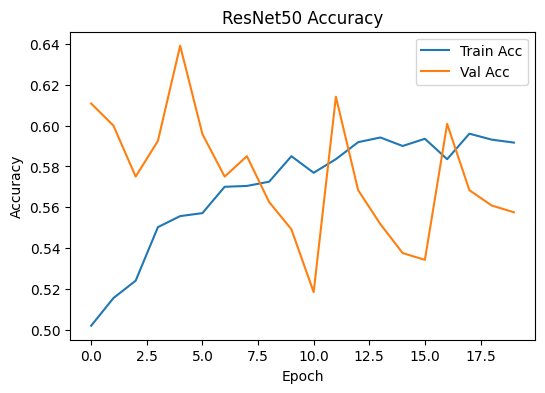

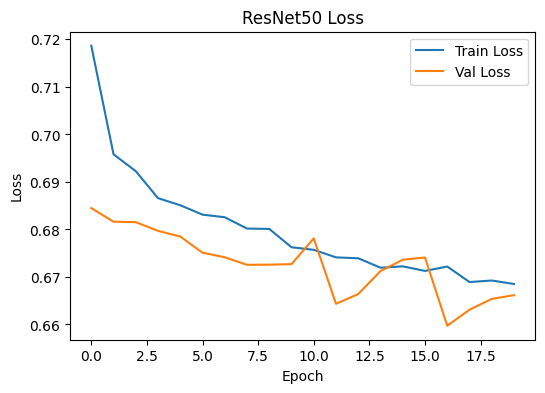

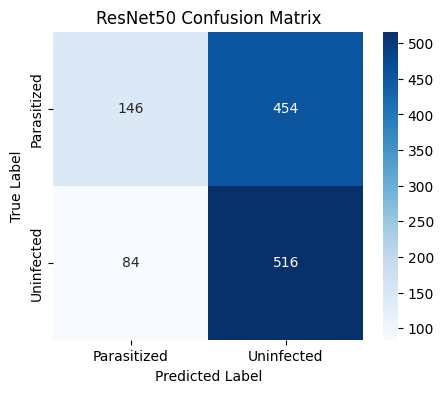

In [46]:
# Evaluate ResNet50
y_true_res, y_pred_res, cm_res = evaluate_model(model_resnet, test_gen, "ResNet50")
plot_training_curves(history_resnet, "ResNet50")
plot_confusion_matrix(cm_res, "ResNet50")

In [47]:
# --------------------- MobileNetV2 --------------------- #
tf.keras.backend.clear_session()
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False,
                             input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
base_mobilenet.trainable = False

z = GlobalAveragePooling2D()(base_mobilenet.output)
z = Dense(128, activation='relu')(z)
z = Dropout(0.5)(z)
output_mobilenet = Dense(1, activation='sigmoid')(z)

model_mobilenet = Model(inputs=base_mobilenet.input, outputs=output_mobilenet)
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

print("\n--- Training MobileNetV2 Model ---")
history_mobilenet = model_mobilenet.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    verbose=1
)


--- Training MobileNetV2 Model ---
Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 69s 409ms/step - accuracy: 0.7286 - loss: 0.5464 - val_accuracy: 0.8250 - val_loss: 0.3731
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 341ms/step - accuracy: 0.8801 - loss: 0.3089 - val_accuracy: 0.8850 - val_loss: 0.2995
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 340ms/step - accuracy: 0.8881 - loss: 0.2690 - val_accuracy: 0.8667 - val_loss: 0.3068
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 340ms/step - accuracy: 0.9036 - loss: 0.2541 - val_accuracy: 0.8767 - val_loss: 0.2820
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 338ms/step - accuracy: 0.9024 - loss: 0.2396 - val_accuracy: 0.8867 - val_loss: 0.2632
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 338ms/step - accuracy: 0.9217 - loss: 0.2156 - val_accuracy: 0.9008 - val_loss: 0.2476
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 339ms/step - accuracy: 0.9183 - loss: 0.2089 - val_accuracy: 0.9008 - val_loss: 0.2431
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 339

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step
MobileNetV2 Performance on Test Set:
  Accuracy:  0.8892
  Precision: 0.8360
  Recall:    0.9683
  F1-score:  0.8973
  AUC-ROC:   0.9723
Confusion Matrix:
 [[486 114]
 [ 19 581]]


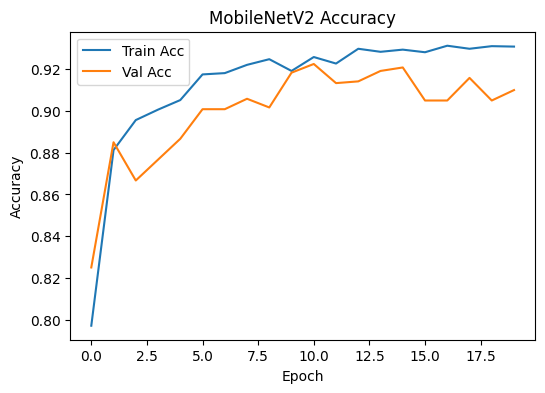

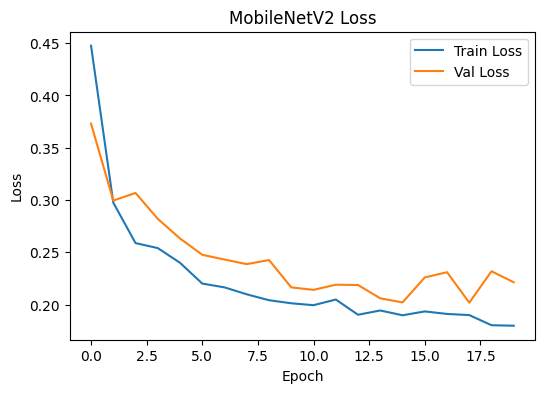

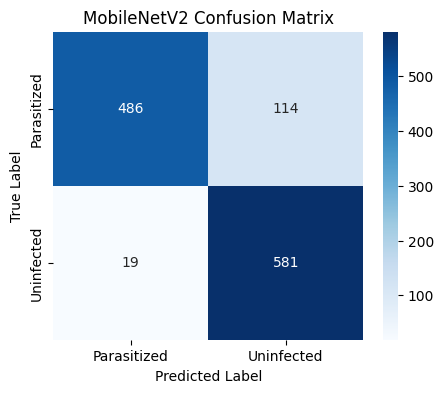

In [48]:
# Evaluate MobileNetV2
y_true_mob, y_pred_mob, cm_mob = evaluate_model(model_mobilenet, test_gen, "MobileNetV2")
plot_training_curves(history_mobilenet, "MobileNetV2")
plot_confusion_matrix(cm_mob, "MobileNetV2")

In [51]:
# --------------------- EfficientNet-B0 --------------------- #
# Clear previous model from memory
tf.keras.backend.clear_session()

# 1. Load the EfficientNet-B0 base model (pre-trained on ImageNet)
base_efficientnet = EfficientNetB0(weights='imagenet', include_top=False,
                                   input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
base_efficientnet.trainable = False  # freeze the base layers

# 2. Add custom classification layers
w = GlobalAveragePooling2D()(base_efficientnet.output)
w = Dense(128, activation='relu')(w)
w = Dropout(0.5)(w)
output_efficientnet = Dense(1, activation='sigmoid')(w)

# 3. Create the EfficientNet-B0 model
model_efficientnet = Model(inputs=base_efficientnet.input, outputs=output_efficientnet)

# 4. Compile the model with the same settings as VGG/ResNet/MobileNet
model_efficientnet.compile(optimizer=Adam(learning_rate=1e-4),
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

print("\n--- Training EfficientNet-B0 Model ---")
history_efficientnet = model_efficientnet.fit(
    train_gen,               # same training generator as the other models
    epochs=EPOCHS,
    validation_data=val_gen, # same validation generator
    verbose=1
)


--- Training EfficientNet-B0 Model ---
Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 91s 441ms/step - accuracy: 0.5120 - loss: 0.6981 - val_accuracy: 0.5000 - val_loss: 0.6949
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 339ms/step - accuracy: 0.4959 - loss: 0.6978 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 339ms/step - accuracy: 0.5018 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 341ms/step - accuracy: 0.4898 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 340ms/step - accuracy: 0.5055 - loss: 0.6948 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 339ms/step - accuracy: 0.4883 - loss: 0.6945 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s 338ms/step - accuracy: 0.4900 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 51s

38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step
EfficientNet-B0 Performance on Test Set:
  Accuracy:  0.5000
  Precision: 0.5000
  Recall:    1.0000
  F1-score:  0.6667
  AUC-ROC:   0.5195
Confusion Matrix:
 [[  0 600]
 [  0 600]]


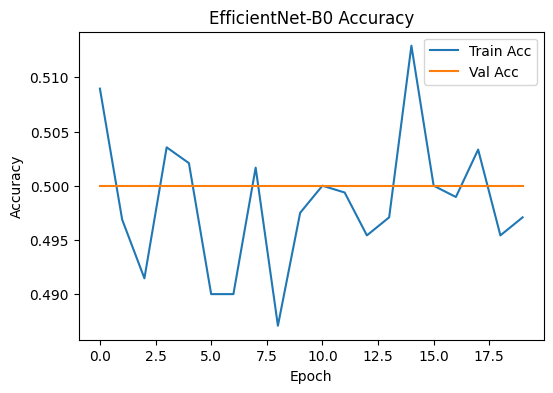

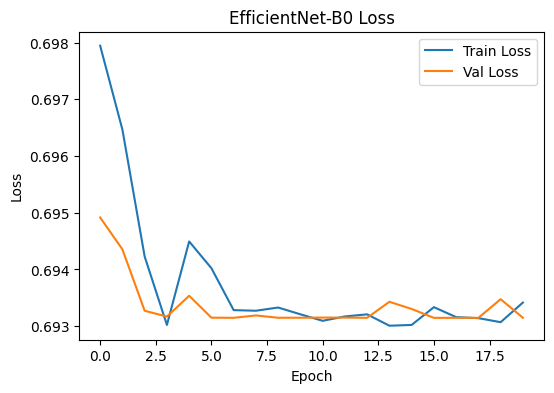

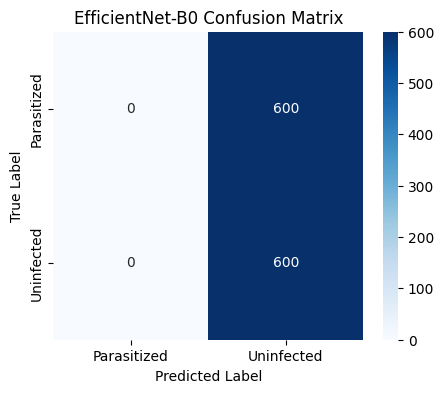

In [52]:
# 5. Evaluate the EfficientNet-B0 model on the test set
y_true_eff, y_pred_eff, cm_eff = evaluate_model(model_efficientnet, test_gen, "EfficientNet-B0")

# 6. Plot the training curves and confusion matrix
plot_training_curves(history_efficientnet, "EfficientNet-B0")
plot_confusion_matrix(cm_eff, "EfficientNet-B0")